# iNaturalist Species Predictions
Downloads images from [iNaturalist](https://www.inaturalist.org/), creates predictions with [BioCLIP](https://imageomics.github.io/bioclip/), and compares the results.

In [1]:
!pip install pybioclip pyinaturalist --quiet

In [2]:
from pyinaturalist import get_observations, Observation
import os
import io
import pandas as pd
from PIL import Image
from bioclip import TreeOfLifeClassifier, Rank

In [3]:
DEVICE = "cpu"
INAT_USER = "john4866"

MAX_IMAGES = 10
IMAGES_DIR = "images"

## Find observations for an iNaturalist user
See [get_observations() documentation](https://pyinaturalist.readthedocs.io/en/stable/modules/pyinaturalist.v1.observations.html#pyinaturalist.v1.observations.get_observations) for other fields to search iNaturalist by.

In [4]:
response = get_observations(user_id=INAT_USER, per_page=MAX_IMAGES)
observations = Observation.from_json_list(response)

## Download images

In [5]:
ids = []
uris = []
paths = []
taxons = []

os.makedirs(IMAGES_DIR, exist_ok=True)

for observation in observations:
    path = os.path.join(IMAGES_DIR, f"{observation.id}.jpg")

    with observation.photos[0].open(size='medium') as infile:
        with open(path, 'wb') as outfile:
            outfile.write(infile.read())

    ids.append(observation.id)
    uris.append(observation.uri)
    paths.append(path)
    taxons.append(observation.taxon.name)

df = pd.DataFrame({
    'id': ids,
    'uri': uris,
    'path': paths,
    'taxon': taxons
})
df.head()

,id,uri,path,taxon
0,213392139,https://www.inaturalist.org/observations/21339...,images/213392139.jpg,Laurasiatheria
1,213392101,https://www.inaturalist.org/observations/21339...,images/213392101.jpg,Ursus americanus
2,213392014,https://www.inaturalist.org/observations/21339...,images/213392014.jpg,Corvus brachyrhynchos
3,188285769,https://www.inaturalist.org/observations/18828...,images/188285769.jpg,Symphyotrichum pilosum


## Make predictions

NOTE: You may see warnings `The secret 'HF_TOKEN' does not exist in your Colab secrets.` and `RuntimeWarning: os.fork()` when running the code block below. Consider setting the HF_TOKEN environment variable to avoid rate limiting errors when running in COLAB. The `os.fork()` warning appears to be a false positive related to [this pytorch issue](https://github.com/pytorch/pytorch/issues/123954).

In [6]:
classifier = TreeOfLifeClassifier(device=DEVICE)
predictions = classifier.predict(df['path'], Rank.SPECIES, k=1)
pred_df = df.join(pd.DataFrame(predictions))
pred_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.63images/s]


,id,uri,path,taxon,file_name,kingdom,phylum,class,order,family,genus,species_epithet,species,common_name,score
0,213392139,https://www.inaturalist.org/observations/21339...,images/213392139.jpg,Laurasiatheria,images/213392139.jpg,Animalia,Chordata,Mammalia,Artiodactyla,Bovidae,Bos,taurus,Bos taurus,aurochs,0.919503
1,213392101,https://www.inaturalist.org/observations/21339...,images/213392101.jpg,Ursus americanus,images/213392101.jpg,Animalia,Chordata,Mammalia,Carnivora,Ursidae,Ursus,americanus,Ursus americanus,Louisiana black bear,0.865530
2,213392014,https://www.inaturalist.org/observations/21339...,images/213392014.jpg,Corvus brachyrhynchos,images/213392014.jpg,Animalia,Chordata,Aves,Passeriformes,Corvidae,Corvus,brachyrhynchos,Corvus brachyrhynchos,American Crow,0.891973
3,188285769,https://www.inaturalist.org/observations/18828...,images/188285769.jpg,Symphyotrichum pilosum,images/188285769.jpg,Plantae,Tracheophyta,Magnoliopsida,Asterales,Asteraceae,Symphyotrichum,bracteolatum,Symphyotrichum bracteolatum,Eaton's aster,0.447099


# Show results

https://www.inaturalist.org/observations/213392139
iNaturalist taxon: Laurasiatheria
BioCLIP species:   Bos taurus
BioCLIP family:    Bovidae


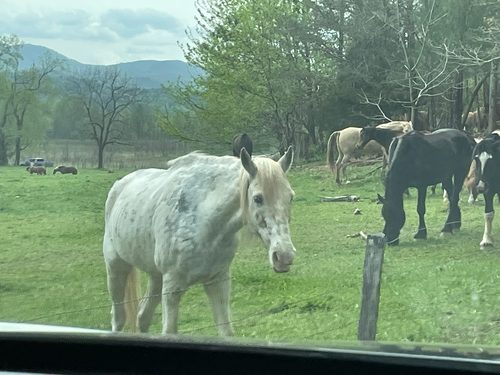



https://www.inaturalist.org/observations/213392101
iNaturalist taxon: Ursus americanus
BioCLIP species:   Ursus americanus
BioCLIP family:    Ursidae


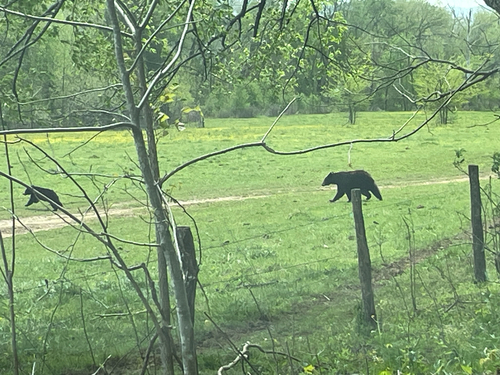



https://www.inaturalist.org/observations/213392014
iNaturalist taxon: Corvus brachyrhynchos
BioCLIP species:   Corvus brachyrhynchos
BioCLIP family:    Corvidae


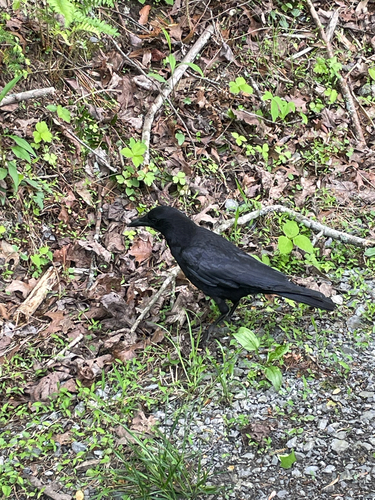



https://www.inaturalist.org/observations/188285769
iNaturalist taxon: Symphyotrichum pilosum
BioCLIP species:   Symphyotrichum bracteolatum
BioCLIP family:    Asteraceae


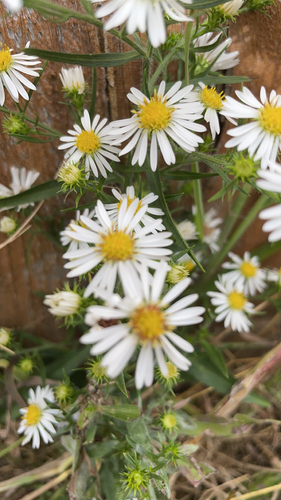

In [7]:
for _, row in pred_df.iterrows():
    path = row['path']
    taxon = row['taxon']
    uri = row['uri']
    species = row['species']
    family = row['family']
    print(uri)
    print("iNaturalist taxon:", taxon)    
    print("BioCLIP species:  ", species)
    print("BioCLIP family:   ", family)
    display(Image.open(path))
    print("\n")